#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [31]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

## Check/Make Paths

In [38]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [39]:
# Robustness Parameter
robustness_parameter = .1

# Reconfiguration Parameters
N_Reconfigurations = 10
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 0.3

# Training meta-parameters
Pre_Epochs = 10
Full_Epochs = 50

# Depth & Height of first Reconfiguration
Initial_Depth = 20
Initial_Height = 50

# Depth & Height Per Reconfiguration
Depth_per_reconfig = 20
Height_per_reconfig = 5

# Number of Datapoints
N_data = 10**3

# Unknown Function
def unknown_f(x):
    return .1*x + .1*(x**2) + np.exp(-np.abs(x)) + np.sin(4*x + x% 2) + x % 1

### Run External/Auxiliary Notebooks

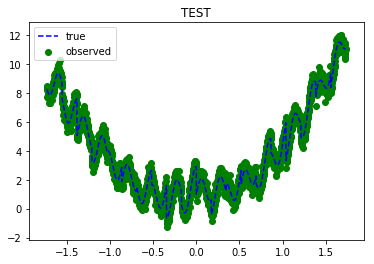

In [40]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

In [41]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets_full  = np.concatenate((data_x,data_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

data_NEU_test = np.concatenate((data_x_test,true_y_test.reshape(-1,D)),1)

# Train NEU-OLS
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [ ]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = get_base_model_Regression(data_x,NEU_targets,10,Initial_Depth,Initial_Height)
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     NEU_targets_full,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - NEU_targets_full)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = NEU_targets_full, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    
    
# Update User #
#-------------#
print('NEU: Ready!')

---

# Train Benchmark Models

In [ ]:
#---------------------#
#  Train Linear-Model #
#---------------------#
if os.path.exists("./outputs/models/Benchmarks/Linear_Regression/saved_model.pb"):
    print('Linear regression trained model already exists: Loading.')
    LinearModel = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Linear regression trained model: Loaded.')
else:
    print('Linear regression model does not exist: Training.')
    LinearModel = get_OLS(data_x,data_y,Full_Epochs_in = Full_Epochs)
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Linear regression model: Saving')
    LinearModel.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Linear regression model: Saved')
    
# Update User #
#-------------#
print('Benchmark Model - Linear Regression: Ready!')

In [ ]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    Deep_GLd = get_base_model_deep_GLd(data_x,
                                   NEU_targets,
                                   Full_Epochs_in = Full_Epochs, 
                                   depth = (N_Reconfigurations*Initial_Depth))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

In [ ]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=get_base_model_deep_Euclidean_Networks(data_x,
                                               NEU_targets,
                                               Full_Epochs_in = Full_Epochs, 
                                               depth = (N_Reconfigurations*Initial_Depth))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

## Make Predictions

In [ ]:
# # Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
OLS_prediction = LinearModel.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_Ed_prediction = Deep_Ed.predict(data_x)

# # Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
OLS_prediction_test = LinearModel.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)

#### Record Error(s)/Prediction Quality

In [ ]:
# Train Results #
#---------------#

# Quantile Losses 
#-----------------#
Results_MAE = np.array([np.mean(np.abs(NEU_OLS_prediction[:,1]  - true_y)),
                        np.mean(np.abs(OLS_prediction  - true_y)),
np.mean(np.abs(Deep_GLd_prediction[:,1]  - true_y)),
np.mean(np.abs(Deep_Ed_prediction[:,1] - true_y))])

Results_MinE = np.array([np.min(np.abs(NEU_OLS_prediction[:,1]  - true_y)),
                         np.min(np.abs(OLS_prediction  - true_y)),
np.min(np.abs(Deep_GLd_prediction[:,1]  - true_y)),
np.min(np.abs(Deep_Ed_prediction[:,1] - true_y))])

Results_MaxE = np.array([np.max(np.abs(NEU_OLS_prediction[:,1]  - true_y)),
                         np.max(np.abs(OLS_prediction  - true_y)),
np.max(np.abs(Deep_GLd_prediction[:,1]  - true_y)),
np.max(np.abs(Deep_Ed_prediction[:,1] - true_y))])

# Variance Losses
#----------------#
Results_MSE = np.array([np.mean(np.power(NEU_OLS_prediction[:,1]  - true_y,2)),
                        np.mean(np.power(OLS_prediction  - true_y,2)),
np.mean(np.power(Deep_GLd_prediction[:,1]  - true_y,2)),
np.mean(np.power(Deep_Ed_prediction[:,1] - true_y,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE = np.array([Robust_MSE_numpy(NEU_OLS_prediction[:,1],true_y),
                         Robust_MSE_numpy(OLS_prediction,true_y),
                         Robust_MSE_numpy(Deep_GLd_prediction[:,1],true_y),
                         Robust_MSE_numpy(Deep_Ed_prediction[:,1],true_y)])

# Write to DataFrame
Results = pd.DataFrame({'MAE': Results_MAE,
                        'MinE': Results_MinE, 
                        'MaxE': Results_MaxE,
                        'Robust MAE':Results_rMAE,
                        'MSE':Results_MSE},
                        index={'NEU-OLS','OLS','Deep GLd','Deep ED'})


# Test Results #
#--------------#

# Quantile Losses 
#-----------------#
Results_MAE_test = np.array([np.mean(np.abs(NEU_OLS_prediction_test[:,1]  - true_y_test)),
                             np.mean(np.abs(OLS_prediction_test  - true_y_test)),
np.mean(np.abs(Deep_GLd_prediction_test[:,1]  - true_y_test)),
np.mean(np.abs(Deep_Ed_prediction_test[:,1] - true_y_test))])

Results_MinE_test = np.array([np.min(np.abs(NEU_OLS_prediction_test[:,1]  - true_y_test)),
                              np.min(np.abs(OLS_prediction_test  - true_y_test)),
np.min(np.abs(Deep_GLd_prediction_test[:,1]  - true_y_test)),
np.min(np.abs(Deep_Ed_prediction_test[:,1] - true_y_test))])

Results_MaxE_test = np.array([np.max(np.abs(NEU_OLS_prediction_test[:,1]  - true_y_test)),
                              np.max(np.abs(OLS_prediction_test  - true_y_test)),
np.max(np.abs(Deep_GLd_prediction_test[:,1]  - true_y_test)),
np.max(np.abs(Deep_Ed_prediction_test[:,1] - true_y_test))])

# Variance Losses
#----------------#
Results_MSE_test = np.array([np.mean(np.power(NEU_OLS_prediction[:,1]  - true_y,2)),
                             np.mean(np.power(OLS_prediction  - true_y,2)),
np.mean(np.power(Deep_GLd_prediction[:,1]  - true_y,2)),
np.mean(np.power(Deep_Ed_prediction[:,1] - true_y,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE_test = np.array([Robust_MSE_numpy(NEU_OLS_prediction_test[:,1],true_y_test),
                              Robust_MSE_numpy(OLS_prediction_test,true_y_test),
                         Robust_MSE_numpy(Deep_GLd_prediction_test[:,1],true_y_test),
                         Robust_MSE_numpy(Deep_Ed_prediction_test[:,1],true_y_test)])

# Write to DataFrame
Results_test = pd.DataFrame({'MAE': Results_MAE_test,
                        'MinE': Results_MinE_test, 
                        'MaxE': Results_MaxE_test,
                        'Robust MAE':Results_rMAE_test,
                        'MSE':Results_MSE_test},
                        index={'NEU-OLS','OLS','Deep GLd','Deep ED'})

# Visualize Predictions

In [ ]:
# #---------------------------#
# # Generate Transformed Data #
# #---------------------------#
# # Initialization of Grid
# visualization_grid = np.random.uniform(-10,10,[10**3,2])
# # Transform Data
# NEU_OLS_prediction_visualization_Greedy = NEU_OLS_Greedy_init.predict(visualization_grid)
# NEU_OLS_prediction_visualization = NEU_OLS.predict(visualization_grid)
# Deep_GLd_prediction_visualization = Deep_GLd.predict(visualization_grid)
# Deep_Ed_prediction_visualization = Deep_Ed.predict(visualization_grid)


# #----------------#
# # Generate Plots #
# #----------------#
# plt.subplot(1, 2, 1)
# plt.scatter(visualization_grid[:,0],visualization_grid[:,1],color='red',marker = '.')
# plt.subplot(1, 2, 2)
# plt.scatter(NEU_OLS_prediction_visualization[:,0],NEU_OLS_prediction_visualization[:,1],color='purple',label='NEU',marker = '.')

# # Initialization
# figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# # Plot Data
# plt.scatter(visualization_grid[:,0],visualization_grid[:,1],color='red',marker = '.')

# # Plot Transformed Data
# plt.scatter(NEU_OLS_prediction_visualization_Greedy[:,0],NEU_OLS_prediction_visualization_Greedy[:,1],color='g',label='NEU_Greedy',marker = '.')
# plt.scatter(NEU_OLS_prediction_visualization[:,0],NEU_OLS_prediction_visualization[:,1],color='purple',label='NEU',marker = '.')
# plt.scatter(Deep_GLd_prediction_visualization[:,0],Deep_GLd_prediction_visualization[:,1],color='black',label='Deep_GLd',marker = '.')
# plt.scatter(Deep_Ed_prediction_visualization[:,0],Deep_Ed_prediction_visualization[:,1],color='orange',label='Deep_Ed',marker = '.')

In [ ]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,data_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='red',label='OLS')
plt.plot(data_x,OLS_prediction,color='pink',label='OLS')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='green',label='NEU-OLS')
plt.plot(data_x,NEU_OLS_greedy_initializations[:,1],color='lightgreen',label='NEU_Greedy_Init')
plt.plot(data_x,Deep_Ed_prediction[:,1],color='orange',label='Deep_Ed')
plt.plot(data_x,Deep_GLd_prediction[:,1],color='purple',label='Deep_GLd')

Succinct graph (results only)

In [ ]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,true_y,label='true',color='grey',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='green',label='NEU-OLS')
plt.plot(data_x,Deep_GLd_prediction[:,1],color='purple',label='Deep_GLd')
plt.plot(data_x,Deep_Ed_prediction[:,1],color='orange',label='Deep_Ed')

 ---

# Report Results

In [ ]:
print('Train Results:')
Results

In [ ]:
print('Test Results:')
Results_test

#### The END